In [3]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [5]:
audio_dir = '../ESC-50/audio/'

In [6]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [7]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [8]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [11]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [12]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [42]:
import time
import librosa
import numpy as np
import soundfile as sf
def load_fold_audio_blockwise(fld, data, blocksize=1024):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    target = []
    for i, sample in f_df.iterrows():
        print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], blocksize=blocksize, always_2d=True, fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

def load_fold_audio(fld, data):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    target = []
    for i, sample in f_df.iterrows():
        print("File Processing", end="", flush=True)
        y, sr = librosa.load(audio_dir + sample['filename'], sr=44100, mono=True)
        len_second = 5.0
        print(".", end="", flush=True)
        y = y[:int(sr*len_second)]
        y = y[np.newaxis, :]
        print(".", end="", flush=True)
        items.append(y)
        target.append(sample.h_category)
        print('Done')
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.array(items), np.array(target)

def load_fold_audio_sub(fld, data, n=10):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = np.array([])
    target = []
    for i, sample in f_df.iterrows():
        y, sr = librosa.load(audio_dir + sample['filename'], sr=44100, mono=True)
        len_second = 5.0
        y = y[:int(sr*len_second)]
        y = y[np.newaxis, :]
        y = np.array_split(y, n, axis=1)
        if items.size == 0:
            items = np.array(y)
        else:
            items = np.concatenate((items, np.array(y)), axis=1)
        target.append(sample.h_category)
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.array(items), np.array(target)

def load_all_audio(data):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        y, sr = librosa.load(audio_dir + sample['filename'], sr=44100, mono=True)
        len_second = 5.0
        y = y[:int(sr*len_second)]
        y = y[np.newaxis, :]
        items.append(y)
        target.append(sample.h_category)
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.array(items), np.array(target)

In [ ]:
c_data, targets = load_fold_audio_blockwise(1, dataset, 44100)
print(c_data.shape)

File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done
File Processing.....Done


In [33]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.33, random_state=42)

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

def gpu_mfcc_shallow_net():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(sr=44100, input_shape=(1, 2048)))
#     model.add(Convolution2D(32, 3, 3, name='conv1', activation='relu'))
#     model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    model.summary()
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=[kmet.mae, kmet.binary_accuracy])
    return model

In [37]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=20, batch_size=20)
clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 8, 1)         296064    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 427,393
Trainable params: 131,329
Non-trainable params: 296,064
_________________________________________________________________
Epoch 1/20
723/723 [==============================] - 8s 11ms/step - loss: 0.5288 - mean_absolute_error: 0.3852 - binary_accuracy:

0.8683473389355743
Confusion matrix, without normalization
[[ 61  42]
 [  5 249]]


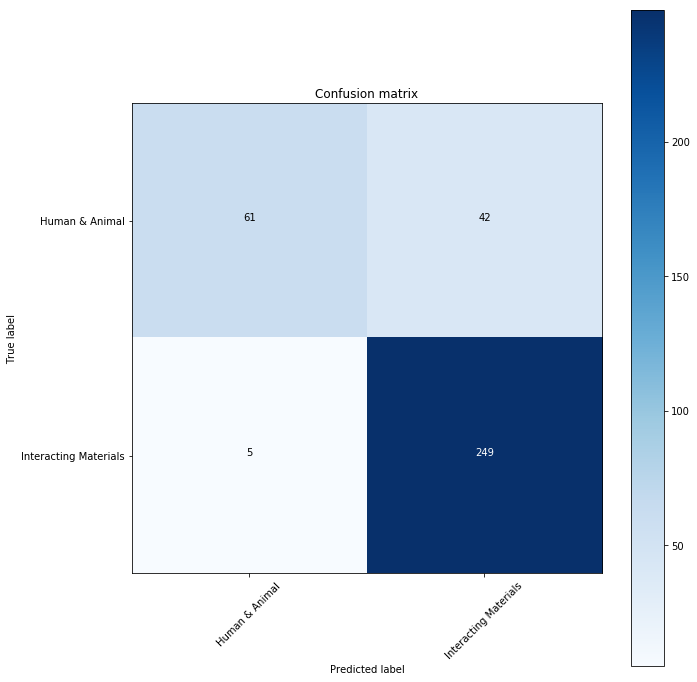

In [38]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()